## Introduction

This kernel shows how to use NBSVM (Naive Bayes - Support Vector Machine) to create a strong baseline for the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) competition. NBSVM was introduced by Sida Wang and Chris Manning in the paper [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf). In this kernel, we use sklearn's logistic regression, rather than SVM, although in practice the two are nearly identical (sklearn uses the liblinear library behind the scenes).

If you're not familiar with naive bayes and bag of words matrices, I've made a preview available of one of fast.ai's upcoming *Practical Machine Learning* course videos, which introduces this topic. Here is a link to the section of the video which discusses this: [Naive Bayes video](https://youtu.be/37sFIak42Sc?t=3745).

该内核展示了如何使用NBSVM（朴素贝叶斯 - 支持向量机）为[毒性评论分类挑战]创建强大的基线（https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge ）比赛。 SBS Wang和Chris Manning在论文[Baselines and Bigrams：Simple，Good Sentiment and Topic Classi fi cation]（https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf）中介绍了NBSVM。 在这个内核中，我们使用sklearn的逻辑回归而不是SVM，尽管在实践中两者几乎相同（sklearn在后台使用liblinear库）。

如果你不熟悉朴素贝叶斯和单词矩阵，我已经预览了fast.ai即将推出的*实用机器学习*课程视频，其中介绍了这个主题。 以下是视频部分的链接：[朴素贝叶斯视频]（https://youtu.be/37sFIak42Sc?t=3745）。

关于本次比赛
您将获得大量维基百科评论，这些评论已被人类评估者标记为有毒行为。毒性的类型是：
toxic 有毒的
severe_toxic 严重毒性
obscene 猥亵
threat 威胁
insult 侮辱
identity_hate 身份恨

您必须创建一个模型，以预测每个评论的每种毒性的概率。

文件说明
train.csv - 训练集，包含带有二进制标签的注释
test.csv - 测试集，您必须预测这些评论的毒性概率。为了阻止手部标记，测试集包含一些评论中未包含的评论。
sample_submission.csv - 格式正确的示例提交文件
test_labels.csv - 测试数据的标签; 值-1表示它不用于评分; （注：比赛结束后加入文件！）

In [25]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [26]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
# 样品提交
subm = pd.read_csv('../input/sample_submission.csv')

## 查看数据

训练数据包含每个评论的行，id，评论文本以及我们将尝试预测的6个不同标签。

In [27]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


这里有几个评论的例子，一个有毒，一个没有标签。

In [28]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [29]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

评论的长度变化很大。

In [30]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

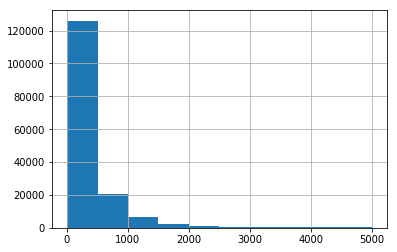

In [45]:
lens.hist();

我们将创建一个要预测的所有标签的列表，我们还将创建一个“无”标签，以便我们可以看到有多少条评论没有标签。 然后我们可以总结数据集。

In [49]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
#　若'none'同行没有1时，即没有标签，'none'值为1
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
len(train),len(test)

(159571, 153164)

我们需要摆脱一些空洞的评论，否则sklearn会抱怨。

In [34]:
COMMENT = 'comment_text'
# 填充空值为"unknown"，便于识别
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

## 构建模型

我们首先创建一个单词*表示，作为*术语文档矩阵*。 我们将按照NBSVM文件中的建议使用ngrams。

我们首先对一列无意义的字符串正则匹配，去掉这些无意义的，利用tfidf提取单词的特征，使用ngram，得到1-ngram 或者2-ngram 特征，就像NBSVM论文中建议的那样。

In [35]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

事实证明，使用TF-IDF可以提供比本文中使用的二值化特征更好的先验。 我认为之前在任何一篇论文中都没有提到这一点，但它将排行榜的得分从0.59提高到0.55。

In [36]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

这将创建一个*稀疏矩阵*，只有少量的非零元素（*存储元素*在下面的表示中）。

In [37]:
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775104 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765755 stored elements in Compressed Sparse Row format>)

这是基本的朴素贝叶斯特征方程：

In [38]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [39]:
x = trn_term_doc
test_x = test_term_doc

一次为一个依赖项拟合模型：

In [40]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [41]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit severe_toxic


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit obscene
fit threat
fit insult
fit identity_hate


最后，创建提交文件。

In [42]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)